##### Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
import scipy.io

In [2]:
def plot_loss_curves(history):

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#### Data Processing

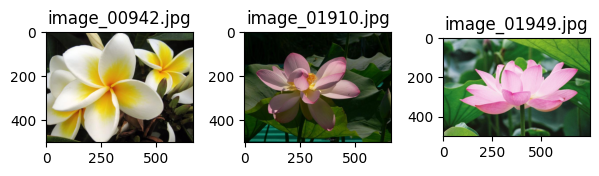

In [3]:
# This code displays three random images from the "jpg/" directory

for i in range(3):
    # Randomly select a file from the "jpg/" directory
    file = random.choice(os.listdir("jpg/"))
    # Get the full path of the selected image
    image_path= os.path.join("jpg/", file)
    # Read the image using matplotlib's imread function
    img=mpimg.imread(image_path)
    # Create a subplot for the current image
    ax=plt.subplot(1,3,i+1)
    # Set the title of the subplot to the file name
    ax.title.set_text(file)
    # Display the image in the subplot
    plt.imshow(img)
    # Adjust the spacing between subplots
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

#### Creating train, validation and test folders

In [2]:
images = []
labels = []

# Iterate over files in the "jpg/" directory
for file in os.listdir("jpg/"):
    # Check if the file ends with ".jpg"
    if file.endswith(".jpg"):
        # Load the image, resize it to (224, 224), and convert it to an array
        image = load_img("jpg/" + file,target_size=(224,224))
        image = img_to_array(image)
        images.append(image)

# Convert the list of images to a numpy array with dtype 'float32'
images = np.array(images,dtype='float32')

# Load labels from the "imagelabels.mat" file
mat_data = scipy.io.loadmat('imagelabels.mat')
data = mat_data['labels']
labels = np.array(data).T

# Print the shape of the labels and images array
print("labels", labels.shape)
print("images", images.shape)
        

labels (8189, 1)
images (8189, 224, 224, 3)


In [5]:
# To see how many files are for each class
pd.DataFrame(pd.DataFrame(labels).groupby(0).size())

,0
0,
1,40
2,60
3,40
4,56
5,65
...,...
98,82
99,63
100,49


In [12]:
# Splitting the data into train_test_data and val_data with a test_size of 0.2 (20%) and a random state of 42
train_test_data, val_data, train_test_labels, val_labels = train_test_split(images, labels, test_size=0.3, random_state=42) 

# Further splitting the train_test_data into train_data and test_data with a test_size of 0.2 (20%) and a random state of 42
train_data, test_data, train_labels, test_labels = train_test_split(train_test_data, train_test_labels, test_size=0.2, random_state=42) 

# Printing the shapes of the different datasets and labels
print("Training data shape:", train_data.shape, ",     Images per class ~ ", round(train_data.shape[0]/102))
print("Testing data shape:", test_data.shape, ",      Images per class ~ ", round(test_data.shape[0]/102))
print("Validation data shape:", val_data.shape, ",   Images per class ~ ", round(val_data.shape[0]/102))
print("Training labels shape:", train_labels.shape)
print("Testing labels shape:", test_labels.shape)
print("Validation labels shape:", val_labels.shape)

Training data shape: (4585, 224, 224, 3) ,     Images per class ~  45
Testing data shape: (1147, 224, 224, 3) ,      Images per class ~  11
Validation data shape: (2457, 224, 224, 3) ,   Images per class ~  24
Training labels shape: (4585, 1)
Testing labels shape: (1147, 1)
Validation labels shape: (2457, 1)


In [6]:
print(len(np.unique(test_labels)), " classes to train")
print(len(np.unique(test_labels)), " classes to validate")
print(len(np.unique(test_labels)), " classes to test")


102  classes to train
102  classes to validate
102  classes to test


##### CNN model

In [13]:
model_1 = tf.keras.Sequential([
    # The first layer, rescales the input pixel values to the range [0, 1] by dividing them by 255.
    tf.keras.layers.Rescaling(1./255,input_shape=(224,224,3)),
    
    # The second layer uses the pre-trained ResNet50 model as a base. ResNet50 is instantiated with the arguments include_top=False (excludes the fully connected layer) and pooling="avg" (applies global average pooling to the output feature maps).
    ResNet50(include_top=False, pooling="avg", weights='imagenet'),
    # The third layer, tf.keras.layers.Dropout, applies dropout regularization to reduce overfitting. The dropout rate is set to 0.5, meaning 50% of the inputs will be randomly set to 0 during training.
    tf.keras.layers.Dropout(0.4),
    # The last layer, tf.keras.layers.Dense, is the output layer with 102 units, representing the number of classes in the classification task. The activation function used is softmax, which outputs class probabilities.
    tf.keras.layers.Dense(102,activation="softmax")
])


model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])


In [86]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 102)               208998    
                                                                 
Total params: 23,796,710
Trainable params: 23,743,590
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
history_1 = model_1.fit(train_data, train_labels-1, batch_size = 16, validation_data = (val_data, val_labels-1), epochs=5, callbacks=[tf.keras.callbacks.ModelCheckpoint("best_acc/best_model", monitor="val_loss", save_best_only=True)])

Epoch 1/5
146/287 [==============>...............] - ETA: 26:19 - loss: 0.1279 - accuracy: 0.9658

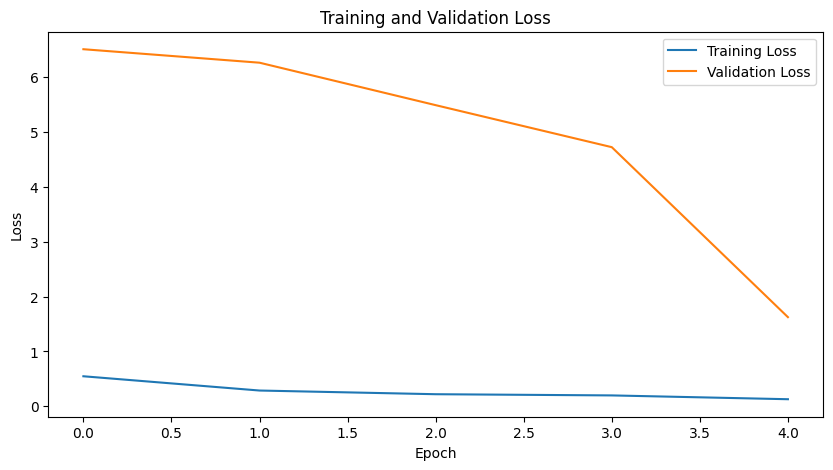

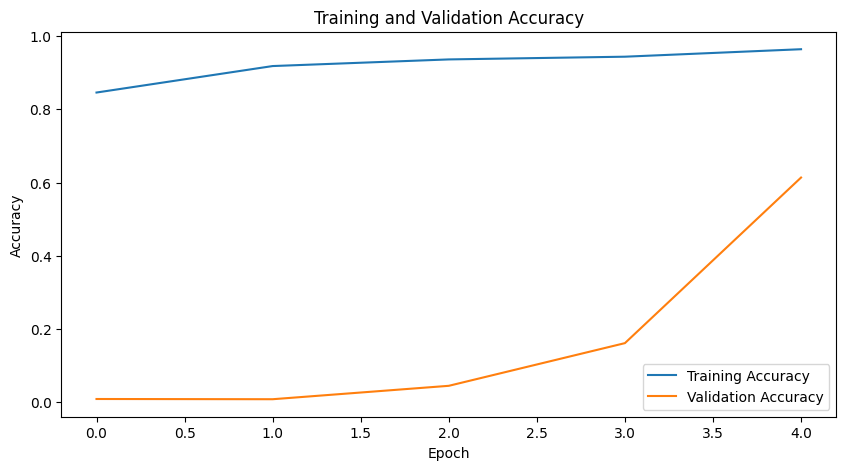

In [53]:
plot_loss_curves(history_1)

In [16]:
model_1.evaluate(test_data, test_labels-1)

52/52 [==============================] - 187s 4s/step - loss: 0.9603 - accuracy: 0.7625


[0.9602868556976318, 0.7625152468681335]

In [22]:
model_1.save('model.h5')